## Set-up

In [69]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [231]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()

    return fig, ax

# Process data

## Data matrix $X$

In [171]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,660.975,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,738.739,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,780.816,845.339,798.132,870.231,891.262,980.735,926.445,845.014,756.975,688.183


In [214]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
df = df[(df.month=='02')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

640


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-02-01_Working day,556.104,525.238,492.826,457.690,453.778,494.431,583.499,687.106,848.986,859.848,...,923.740,959.545,936.638,867.995,741.994,649.306,Calabria,2021,02,Working day
Calabria_2021-02-02_Working day,555.060,471.104,481.685,472.618,480.733,488.947,562.194,668.604,816.705,921.285,...,906.994,945.464,926.279,869.236,771.348,658.354,Calabria,2021,02,Working day
Calabria_2021-02-03_Working day,544.226,468.169,440.565,412.404,401.278,438.749,516.628,609.530,783.423,818.952,...,861.864,830.798,880.445,799.779,692.125,606.242,Calabria,2021,02,Working day


In [215]:
X = df.drop(unit_info.columns, axis=1)
# X = X.div(X.max(axis=1), axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-02-01_Working day,556.104,525.238,492.826,457.690,453.778,494.431,583.499,687.106,848.986,859.848,...,687.059,737.334,747.424,840.354,923.740,959.545,936.638,867.995,741.994,649.306
Calabria_2021-02-02_Working day,555.060,471.104,481.685,472.618,480.733,488.947,562.194,668.604,816.705,921.285,...,791.434,890.847,816.208,753.795,906.994,945.464,926.279,869.236,771.348,658.354
Calabria_2021-02-03_Working day,544.226,468.169,440.565,412.404,401.278,438.749,516.628,609.530,783.423,818.952,...,677.941,714.970,752.660,757.911,861.864,830.798,880.445,799.779,692.125,606.242
Calabria_2021-02-04_Working day,486.652,450.714,432.136,418.269,408.906,437.192,501.508,558.931,705.918,745.691,...,702.362,724.162,797.728,721.861,860.050,927.733,927.940,815.605,770.994,683.812
Calabria_2021-02-05_Working day,530.680,459.248,429.061,435.680,435.180,485.819,535.297,627.255,802.398,865.430,...,732.084,767.463,810.516,806.789,917.734,928.989,912.861,769.955,694.454,611.833


# Initialization matrices $W_{init}$, $H_{init}$

In [ ]:
cons_df = pd.read_excel('data/consumption/consumption_chart.xlsx')
cons_df.head(3)

,Regione,Settore corretto,Sum of Consumo corretto,year,Zone
0,Veneto,Agricoltura,708.884874,2018,North
1,Veneto,Domestico,5595.518524,2018,North
2,Veneto,Industria,14741.332908,2018,North


In [ ]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_cons_df = pd.pivot_table(cons_df[cons_df.year == 2022], values='Sum of Consumo corretto', index='Zone', columns='Settore corretto', aggfunc='sum')
# We divide by 365 days to have an estimation of the daily consumption per sector
# Unit is in GWh so we multiply by 1000 to obtain MWh
region_cons_df = 1000 * region_cons_df / 365
# We remove agriculture since it is too small
region_cons_df.drop('Agricoltura', axis=1, inplace=True)
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,5501.656162,2221.970137,5414.447775
Centre-North,14999.389266,30077.572003,20843.587553
Centre-South,38254.498504,40091.870016,50532.457222
North,82567.062118,233396.049923,132834.918159
Sardinia,6204.567797,9481.303726,5893.547704
Sicily,15815.759466,16362.554953,14058.673962
South,13438.257825,24568.937381,14591.370523


In [ ]:
# Now se should find 4 components (according to the FPCA analysis ran before), so we need to add one more.
# Given that Sardinia and South/Sicily have a similar sector mix with different daily curves and that they seem to differ mainly in type of industry, we choose to split the Industry consumption
# From the industry subsector distribution it seems that the "metalli non ferrosi" is responsible of the deviance of Sardinia from South and Sicily

imcei_df = pd.read_excel('/Users/guillaume/Documents/GitHub/BSS/data/consumption/export_imcei_region_chart.xlsx')
imcei_df.head(3)

,Anno,Mese,Zone,Regione,Settore,Tipo Tensione,Imcei Mensile,Consumi (Gwh)
0,2021,Febbraio,North,Lombardia,SIDERURGIA,AT,56.278856,609.47
1,2021,Febbraio,North,Friuli-Venezia Giulia,SIDERURGIA,AT,16.857709,182.56
2,2021,Febbraio,North,Veneto,SIDERURGIA,AT,16.632398,180.12


In [ ]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_imcei_df = pd.pivot_table(imcei_df, values='Consumi (Gwh)', index='Zone', columns='Settore', aggfunc='sum')
region_imcei_df = region_imcei_df.fillna(0).div(region_imcei_df.fillna(0).sum(axis=1), axis=0)
region_imcei_df

Settore,ALIMENTARE,ALTRI,CARTARIA,CEMENTO CALCE E GESSO,CERAMICHE E VETRARIE,CHIMICA,MECCANICA,METALLI NON FERROSI,MEZZI DI TRASPORTO,SIDERURGIA
Zone,,,,,,,,,,
Calabria,0.000000,0.732288,0.000000,0.181330,0.000000,0.086383,0.000000,0.000000,0.000000,0.000000
Centre-North,0.018280,0.149364,0.256549,0.036830,0.048687,0.101659,0.099522,0.115424,0.031796,0.141888
Centre-South,0.033223,0.225481,0.047489,0.090762,0.013459,0.092326,0.035709,0.071985,0.106571,0.282995
North,0.013951,0.138182,0.009241,0.025275,0.023056,0.092524,0.082830,0.086433,0.018670,0.509838
Sardinia,0.030628,0.060916,0.008278,0.042906,0.000000,0.253736,0.037780,0.565756,0.000000,0.000000
Sicily,0.026833,0.274475,0.000000,0.144020,0.000000,0.181337,0.178375,0.018193,0.007023,0.169744
South,0.103417,0.237429,0.010274,0.209634,0.021636,0.070357,0.011814,0.003816,0.103443,0.228179


In [ ]:
region_cons_df['Industria 2'] = region_imcei_df['METALLI NON FERROSI'] * region_cons_df['Industria']
region_cons_df['Industria 1'] = region_cons_df['Industria'] - region_cons_df['Industria 2']
region_cons_df = region_cons_df[['Domestico', 'Servizi', 'Industria 1', 'Industria 2']]
region_cons_df.index = region_cons_df.index.str.replace('-', '.')
region_cons_df

Settore corretto,Domestico,Servizi,Industria 1,Industria 2
Zone,,,,
Calabria,5501.656162,5414.447775,2221.970137,0.000000
Centre.North,14999.389266,20843.587553,26605.886041,3471.685962
Centre.South,38254.498504,50532.457222,37205.846540,2886.023477
North,82567.062118,132834.918159,213222.835078,20173.214845
Sardinia,6204.567797,5893.547704,4117.203240,5364.100486
Sicily,15815.759466,14058.673962,16064.873080,297.681874
South,13438.257825,14591.370523,24475.181235,93.756146


In [ ]:
W_init = df[['region']]
W_init = W_init.merge(region_cons_df, how='left', left_on='region', right_index=True)
W_init.drop('region', axis=1, inplace=True)
W_init

,Domestico,Servizi,Industria 1,Industria 2
Calabria_2021-02-01_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-02-02_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-02-03_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-02-04_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-02-05_Working day,5501.656162,5414.447775,2221.970137,0.000000
...,...,...,...,...
South_2022-02-22_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-02-23_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-02-24_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-02-25_Working day,13438.257825,14591.370523,24475.181235,93.756146


In [ ]:
# Our initial guess for the matrix of components is a constant curve. The condition on the norm of the components being 1 yields S_k = (1/24, ..., 1/24)
H_init = np.ones((4, 24)) / 24

# NMF

## Random initialization

1180 iterations
1.2722282754714185 error


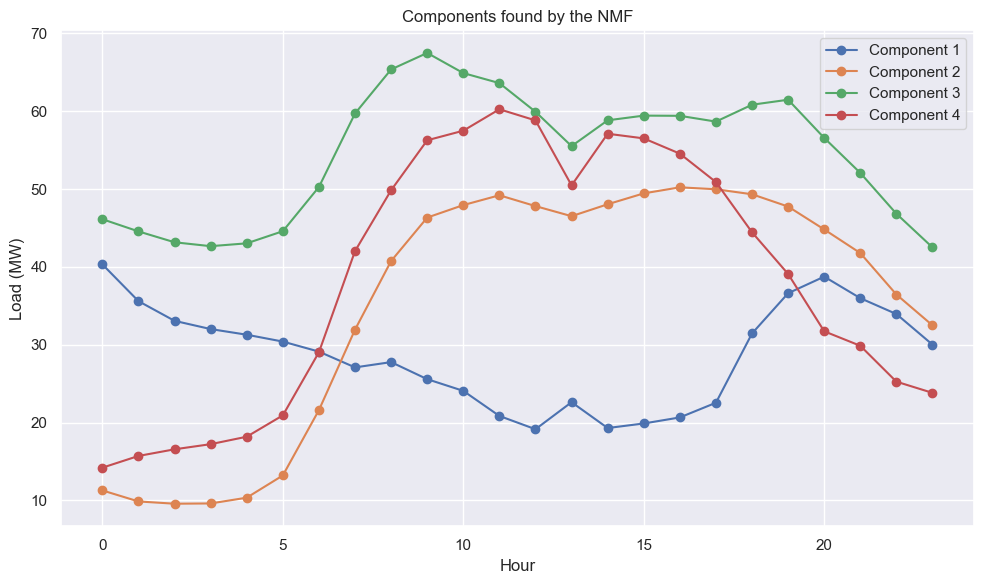

In [216]:
n_components = 4
random_state = None
tol = 1e-5
init = 'random'
max_iter = 4000
solver = 'mu'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter
)

W = model.fit_transform(X)
H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF")

plt.tight_layout()

## Initialization with year level sector-wise consumption

### Run NMF

10 iterations
1.01905925415024 error


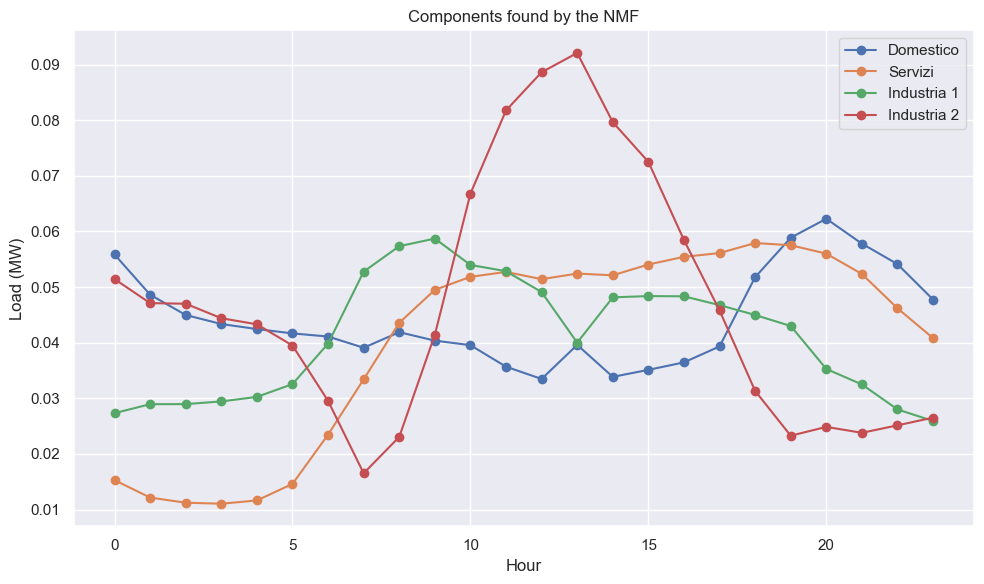

In [233]:
n_components = 4
random_state = None
tol = 1e-5
init = 'custom'
max_iter = 4000
solver = 'mu'
verbose = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter,
    verbose=verbose
)

W = model.fit_transform(
    X.values,
    W=W_init.values.copy(order='C'),
    H=H_init
)

H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF", component_names=W_init.columns)

plt.tight_layout()

___

# Tests

In [194]:
W_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, Calabria_2021-10-01_Working day to South_2022-10-31_Working day
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Domestico    702 non-null    float64
 1   Servizi      702 non-null    float64
 2   Industria 1  702 non-null    float64
 3   Industria 2  702 non-null    float64
dtypes: float64(4)
memory usage: 27.4+ KB


In [189]:
W_init[W_init.isnull().any(axis=1)]

,Domestico,Servizi,Industria 1,Industria 2
Centre.North_2018-10-01_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-02_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-03_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-04_Working day,NaN,NaN,NaN,NaN
Centre.North_2018-10-05_Working day,NaN,NaN,NaN,NaN
...,...,...,...,...
Centre.South_2022-10-25_Working day,NaN,NaN,NaN,NaN
Centre.South_2022-10-26_Working day,NaN,NaN,NaN,NaN
Centre.South_2022-10-27_Working day,NaN,NaN,NaN,NaN
Centre.South_2022-10-28_Working day,NaN,NaN,NaN,NaN


In [136]:
W_init.values.copy(order='C')

array([[ 5501.65616164,  5414.44777534,  2221.97013699,     0.        ],
       [ 5501.65616164,  5414.44777534,  2221.97013699,     0.        ],
       [ 5501.65616164,  5414.44777534,  2221.97013699,     0.        ],
       ...,
       [13438.25782466, 14591.37052329, 24475.18123511,    93.75614571],
       [13438.25782466, 14591.37052329, 24475.18123511,    93.75614571],
       [13438.25782466, 14591.37052329, 24475.18123511,    93.75614571]])

In [137]:
W_init

,Domestico,Servizi,Industria 1,Industria 2
Calabria_2021-10-01_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-04_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-05_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-06_Working day,5501.656162,5414.447775,2221.970137,0.000000
Calabria_2021-10-07_Working day,5501.656162,5414.447775,2221.970137,0.000000
...,...,...,...,...
South_2022-10-25_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-10-26_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-10-27_Working day,13438.257825,14591.370523,24475.181235,93.756146
South_2022-10-28_Working day,13438.257825,14591.370523,24475.181235,93.756146


In [135]:
H_init

array([[0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.041

In [98]:
import sklearn
print(sklearn.__version__)

1.3.2


In [133]:
H_init.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [78]:
df.dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [70]:
np.ones((3,4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [80]:
unit_info = X.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(X.index)
df = pd.concat([X, unit_info], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,773.431,828.180,831.509,758.732,669.630,596.548,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,764.207,819.056,825.176,754.773,706.062,629.708,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,891.262,980.735,926.445,845.014,756.975,688.183,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,601.762,548.971,516.841,511.542,497.733,518.294,582.056,675.144,745.112,926.874,...,885.152,888.862,866.911,797.831,689.408,613.111,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,522.253,460.861,442.133,442.172,434.206,446.617,465.662,510.365,557.035,719.846,...,797.872,813.154,792.839,753.642,690.855,625.452,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,1308.316,1196.696,1118.799,1120.978,1261.263,1301.362,1596.961,1820.374,2114.503,2419.050,...,2609.307,2646.229,2607.138,2485.261,2204.701,1928.912,South,2022,12,Working day
South_2022-12-28_Working day,1414.026,1224.167,1015.749,955.943,936.003,1024.786,1263.846,1629.519,2071.388,2444.281,...,3033.573,3064.172,3021.570,2853.291,2550.622,2062.207,South,2022,12,Working day
South_2022-12-29_Working day,1825.454,1392.857,1556.300,1471.466,1446.057,1525.885,1747.927,1865.976,2035.924,2345.770,...,2425.699,2538.385,2462.135,2344.187,2048.957,1735.955,South,2022,12,Working day
South_2022-12-30_Working day,1528.905,1225.758,1115.273,1035.417,1050.114,1129.062,1317.993,1661.784,1885.976,2393.216,...,2543.212,2623.629,2664.239,2492.585,2206.210,2122.022,South,2022,12,Working day
